In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

from sklearn.metrics import confusion_matrix

import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from pymagnitude import *
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

num train:  38592
num test:  16540


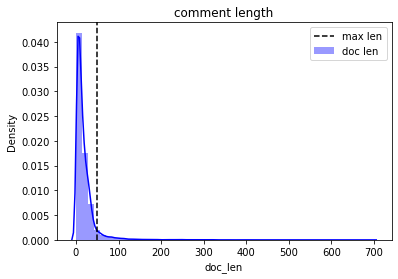

In [3]:
train_df = pd.read_csv('hsd/Reddit/train.csv', sep=',', header=0, index_col=0)
test_df = pd.read_csv('hsd/Reddit/test.csv', sep=',', header=0, index_col=0)
validate_df = pd.read_csv('hsd/Reddit/validate.csv', sep=',', header=0, index_col=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ['class']
y_train = list(map(lambda number: 1 if number[0] == 2 else 0, train_df[label_names].values.tolist()))
y_train = to_categorical(y_train)

y_test = list(map(lambda number: 1 if number[0] == 2 else 0, test_df[label_names].values.tolist()))
y_test = to_categorical(y_test)

#visualize word distribution
train_df['doc_len'] = train_df['lemmatized_text'].apply( lambda words: len(str(words).split()) )
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int) + 2
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [4]:
MAX_NB_WORDS = 100000

raw_docs_train = train_df['lemmatized_text'].apply(lambda words: str(words)).tolist()
raw_docs_test = test_df['lemmatized_text'].apply(lambda words: str(words)).tolist() 
raw_docs_validate = validate_df['lemmatized_text'].apply(lambda words: str(words)).tolist() 
num_classes = len(label_names)

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(raw_docs_train + raw_docs_test + raw_docs_validate)  #leaky
word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_test = tokenizer.texts_to_sequences(raw_docs_test)
word_seq_val = tokenizer.texts_to_sequences(raw_docs_validate)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)
word_seq_val = sequence.pad_sequences(word_seq_val, maxlen=max_seq_len)

tokenizing input data...
dictionary size:  42027


In [5]:
embed_dim = 300 
# hyperparams
# hyperparams
LAYERS = 5  # hidden layers count
LR = 0.001  # learning rate
OPTIM = tf.keras.optimizers.Adam  # optimizer
EPOCHS = 10

# params
HL_NODES = 128  # hidden layer nodes
BATCH_SIZE = 200  # size of input batch
INIT = 'random_normal'  # trainable param initializer

In [6]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
vecs = Magnitude(MagnitudeUtils.download_model('http://magnitude.plasticity.ai/fasttext/medium/crawl-300d-2M.magnitude'))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = vecs.query(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1


In [7]:
class MetricsCallback(Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()
        self.val_f1s0 = []
        self.val_f1s1 = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.asarray(tf.argmax(self.model.predict(word_seq_test), axis=1))
        val_true = np.asarray(tf.argmax(y_test, axis=1))
        c_m = confusion_matrix(val_true, val_predict, labels=[0, 1])
        self.val_f1s0.append(2*float(c_m[0][0])/(2*float(c_m[0][0]) + c_m[0][1] + c_m[1][0]))
        self.val_f1s1.append(2*float(c_m[1][1])/(2*float(c_m[1][1]) + c_m[1][0] + c_m[0][1]))

In [8]:
class DenseModel():
    def __init__(self, nb_words, embed_dim, embedding_matrix, max_seq_len, name='dense_model', **kwargs):
        # hyperparams
        self.layers = LAYERS if 'layers' not in kwargs else kwargs['layers']
        self.lr = LR if 'lr' not in kwargs else kwargs['lr']
        self.optim = OPTIM(learning_rate=self.lr) if 'optim' not in kwargs else kwargs['optim'](learning_rate=self.lr)
        self.epochs = EPOCHS if 'epochs' not in kwargs else kwargs['epochs']
        
        # params
        self.hl_nodes = HL_NODES if 'hl_nodes' not in kwargs else kwargs['hl_nodes']
        self.batch_size = BATCH_SIZE if 'batch_size' not in kwargs else kwargs['batch_size']
        self.init = INIT if 'init' not in kwargs else kwargs['init']
        
        # layers
        self.model = Sequential()
        self.model.add(Embedding(nb_words, embed_dim,
                    weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
        self.model.add(Dense(self.hl_nodes, activation='relu', name='dense_1',
                  kernel_initializer=self.init, bias_initializer=self.init))
        for layer in range(self.layers)[1:]:
            self.model.add(Dense(self.hl_nodes, activation='relu', name='dense_{}'.format(layer+1),
                      kernel_initializer=self.init, bias_initializer=self.init))
                      
        self.model.add(Flatten(name='wt_flatten'))
        self.model.add(Dense(2, activation='softmax', name='predictions',
                    kernel_initializer='random_normal', bias_initializer='random_normal'))

        self.name = name
        self.mc = MetricsCallback()
    
    def summary(self):
        return self.model.summary()
    
    def compile(self):
        self.model.compile(optimizer=self.optim,
                           loss=tf.keras.losses.CategoricalCrossentropy(),
                           metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    def fit(self, X_tr, y_tr, X_ev, y_ev):
        return self.model.fit(X_tr, y_tr, batch_size=self.batch_size, epochs=self.epochs,
                              validation_data=(X_ev, y_ev), callbacks=[self.mc])
    
    def predict(self, X_t):
        return self.model.predict(X_t)
    
    def save(self, file_name):
        self.model.save(file_name)

In [9]:
def models_comparison_bars(df, title, interval=2, save_file=None):
    fig, axs = plt.subplots(1, 3, figsize=(16, 4))
    
    labels = [i+1 if i%interval == 0 else '' for i in range(len(df))]
    x = range(len(labels))
    acc = df['acc'].values
    f1s0 = df['f1s0'].values
    f1s1 = df['f1s1'].values
    
    max_acc_id = np.argmax(acc)
    max_f1s0_id = np.argmax(f1s0)
    max_f1s1_id = np.argmax(f1s1)
    
    axs[0].bar(x, acc, color='r')
    axs[0].set_xlabel('Model number')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(labels)
    axs[0].set_ylim([0, 1])
    axs[0].set_title('Accuracy | max ({}) at: {}'.format(np.round(np.max(acc), 2), max_acc_id+1))
    axs[0].patches[max_acc_id].set_facecolor('g')
    
    axs[1].bar(x, f1s0, color='b')
    axs[1].set_xlabel('Model number')
    axs[1].set_ylabel('F1 score (no hate)')
    axs[1].set_title('F1 score (no hate) | max ({}) at: {}'.format(np.round(np.max(f1s0), 2), max_f1s0_id+1))
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(labels)
    axs[1].set_ylim([0, 1])
    axs[1].patches[max_f1s0_id].set_facecolor('g')
    
    axs[2].bar(x, f1s1, color='m')
    axs[2].set_xlabel('Model number')
    axs[2].set_ylabel('F1 score (hate speech)')
    axs[2].set_title('F1 score (hate speech) | max ({}) at: {}'.format(np.round(np.max(f1s1), 2),
                                                                       max_f1s1_id+1))
    axs[2].set_xticks(x)
    axs[2].set_xticklabels(labels)
    axs[2].set_ylim([0, 1])
    axs[2].patches[max_f1s1_id].set_facecolor('g')
    
    fig.suptitle(title)
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [10]:
def get_hyperparams_options(layers_options = [1, 2, 3, 4], lr_options = [0.01, 0.001],
                            optim_options = [tf.keras.optimizers.Adam, tf.keras.optimizers.SGD],
                            epochs_options = [5, 10, 15]):
    hp_options = []
    for epochs in [epochs_options[-1]]:  # changed to process 15 epochs (eval. after each 5)
        for lr in lr_options:
            for optim in optim_options:
                for layer in layers_options:
                    hp_options.append({'lr': lr, 'optim': optim, 'epochs': epochs, 'layers': layer})
    return hp_options

In [11]:
def find_hyper_parameters(options, shape, save_path = 'results/en_dense/hyperparams_research.csv', epochs_options = [5, 10, 15]):    
    if not os.path.exists(save_path):
        hp_results = []
        for i, opts in enumerate(options):
            print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(hp_options), opts))

            hp_model = DenseModel(nb_words, embed_dim, embedding_matrix, max_seq_len, **opts)
            hp_model.compile()
            hp_history = hp_model.fit(word_seq_train, y_train, word_seq_test, y_test)

            # append means for 5, 10 and 15 epochs
            for eps in epochs_options:
                hp_results.append({'acc': np.mean(hp_history.history['categorical_accuracy'][:eps]),
                                   'val_acc': np.mean(hp_history.history['val_categorical_accuracy'][:eps]),
                                   'loss': np.mean(hp_history.history['val_loss'][:eps]),
                                   'f1s0': np.mean(hp_model.mc.val_f1s0[:eps]),
                                   'f1s1': np.mean(hp_model.mc.val_f1s1[:eps])})

        hp_results_df = pd.DataFrame(hp_results)
        hp_results_df.to_csv(save_path)
    else:
        hp_results_df = pd.read_csv(save_path, index_col=0)
    return hp_results_df

In [12]:
hp_options = get_hyperparams_options()
hp_results_df = find_hyper_parameters(options = hp_options, shape=(50, 100, 3, ))

6 - val_loss: 0.2665 - val_categorical_accuracy: 0.9080
Epoch 8/15
193/193 [==============================] - 1s 8ms/step - loss: 0.1871 - categorical_accuracy: 0.9376 - val_loss: 0.2640 - val_categorical_accuracy: 0.9113
Epoch 9/15
193/193 [==============================] - 2s 8ms/step - loss: 0.1752 - categorical_accuracy: 0.9409 - val_loss: 0.2668 - val_categorical_accuracy: 0.9114
Epoch 10/15
193/193 [==============================] - 2s 8ms/step - loss: 0.1679 - categorical_accuracy: 0.9436 - val_loss: 0.2766 - val_categorical_accuracy: 0.9077
Epoch 11/15
193/193 [==============================] - 2s 8ms/step - loss: 0.1644 - categorical_accuracy: 0.9437 - val_loss: 0.2809 - val_categorical_accuracy: 0.9080
Epoch 12/15
193/193 [==============================] - 2s 8ms/step - loss: 0.1548 - categorical_accuracy: 0.9492 - val_loss: 0.2844 - val_categorical_accuracy: 0.9079
Epoch 13/15
193/193 [==============================] - 1s 8ms/step - loss: 0.1458 - categorical_accuracy: 0.952

In [13]:
pd.DataFrame(hp_options).head()

,lr,optim,epochs,layers
0,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,1
1,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,2
2,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,3
3,0.01,<class 'tensorflow.python.keras.optimizer_v2.a...,15,4
4,0.01,<class 'tensorflow.python.keras.optimizer_v2.g...,15,1


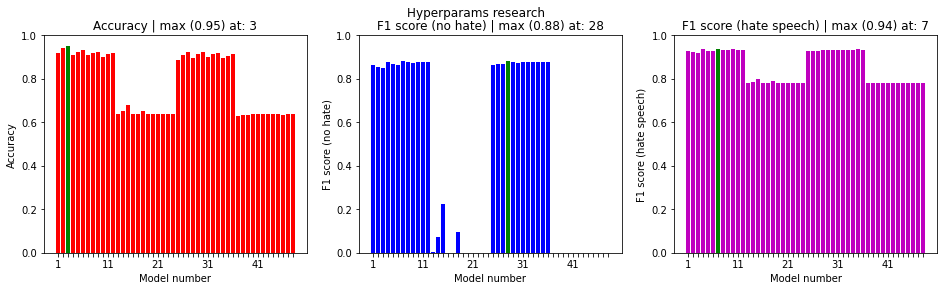

In [14]:
models_comparison_bars(hp_results_df, title='Hyperparams research', interval=10,
                       save_file='results/en_dense/hyperparams_research.png')

In [15]:
best_h_num = 35
'Best one: {} with {} run epochs'.format(hp_options[int((best_h_num-1)/3)],
                                         ((best_h_num-1)%3)*5 if (best_h_num-1)%3 != 0 else 15)

"Best one: {'lr': 0.001, 'optim': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'epochs': 15, 'layers': 4} with 5 run epochs"

In [16]:
def get_params_options( hl_nodes_options = [64, 128],
                        init_options = ['random_uniform', 'random_normal'],
                        batch_size_options = [100, 200]):

    p_options = []
    for hl_nodes in hl_nodes_options:
        for batch_size in batch_size_options:
            for init in init_options:
                p_options.append({'hl_nodes': hl_nodes, 'batch_size': batch_size, 'init': init})
    return p_options

In [17]:
p_options = get_params_options()
pd.DataFrame(p_options).head()

,hl_nodes,batch_size,init
0,64,100,random_uniform
1,64,100,random_normal
2,64,200,random_uniform
3,64,200,random_normal
4,128,100,random_uniform


In [18]:
def find_parameters(options, shape, save_path = 'results/en_dense/params_research.csv', epochs_options = [5, 10, 15]):
    if not os.path.exists(save_path):
        p_results = []
        for i, opts in enumerate(p_options):
            print('\nResearching for {}/{} | Hyperparams: {}\n'.format(i+1, len(p_options), opts))

            p_model = DenseModel(nb_words, embed_dim, embedding_matrix, max_seq_len, **opts)
            p_model.compile()
            p_history = p_model.fit(word_seq_train, y_train, word_seq_test, y_test)

            p_results.append({'acc': np.mean(p_history.history['categorical_accuracy']),
                            'val_acc': np.mean(p_history.history['val_categorical_accuracy']),
                            'loss': np.mean(p_history.history['val_loss']),
                            'f1s0': np.mean(p_model.mc.val_f1s0),
                            'f1s1': np.mean(p_model.mc.val_f1s1)})

        p_results_df = pd.DataFrame(p_results)
        p_results_df.to_csv(save_path)
    else:
        p_results_df = pd.read_csv(save_path, index_col=0)
    return p_results_df

In [19]:
p_results_df = find_parameters(options = p_options, shape = (12, 300, ))

In [20]:
p_results_df.head()

,acc,val_acc,loss,f1s0,f1s1
0,0.905426,0.915786,0.254030,0.878965,0.935418
1,0.907214,0.915254,0.256435,0.879296,0.934672
2,0.898943,0.915979,0.253230,0.880410,0.935228
3,0.902786,0.915865,0.253439,0.880186,0.935156
4,0.909927,0.915133,0.254385,0.878267,0.934845


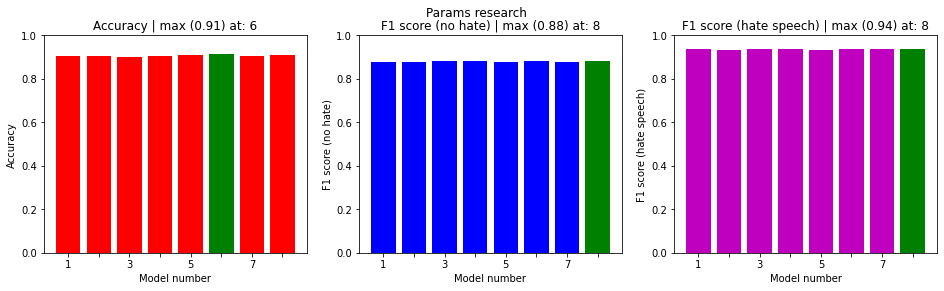

In [21]:
models_comparison_bars(p_results_df, title='Params research', save_file='results/en_dense/params_research.png')

In [22]:
best_num = 8
'Best one: {}'.format(p_options[best_num-1])

"Best one: {'hl_nodes': 128, 'batch_size': 200, 'init': 'random_normal'}"

In [23]:
model = DenseModel(nb_words, embed_dim, embedding_matrix, max_seq_len)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 300)           12608100  
_________________________________________________________________
dense_1 (Dense)              (None, 50, 128)           38528     
_________________________________________________________________
dense_2 (Dense)              (None, 50, 128)           16512     
_________________________________________________________________
dense_3 (Dense)              (None, 50, 128)           16512     
_________________________________________________________________
dense_4 (Dense)              (None, 50, 128)           16512     
_________________________________________________________________
dense_5 (Dense)              (None, 50, 128)           16512     
_________________________________________________________________
wt_flatten (Flatten)         (None, 6400)            

In [24]:
model.compile()
history = model.fit(word_seq_train, y_train, word_seq_test, y_test)
model.save('models/en_dense.model')

Epoch 1/10
193/193 [==============================] - 3s 14ms/step - loss: 0.5394 - categorical_accuracy: 0.7190 - val_loss: 0.2676 - val_categorical_accuracy: 0.9133
Epoch 2/10
193/193 [==============================] - 2s 12ms/step - loss: 0.2649 - categorical_accuracy: 0.9112 - val_loss: 0.2496 - val_categorical_accuracy: 0.9147
Epoch 3/10
193/193 [==============================] - 2s 12ms/step - loss: 0.2579 - categorical_accuracy: 0.9134 - val_loss: 0.2529 - val_categorical_accuracy: 0.9139
Epoch 4/10
193/193 [==============================] - 2s 12ms/step - loss: 0.2484 - categorical_accuracy: 0.9183 - val_loss: 0.2471 - val_categorical_accuracy: 0.9175
Epoch 5/10
193/193 [==============================] - 2s 12ms/step - loss: 0.2478 - categorical_accuracy: 0.9166 - val_loss: 0.2495 - val_categorical_accuracy: 0.9165
Epoch 6/10
193/193 [==============================] - 2s 12ms/step - loss: 0.2456 - categorical_accuracy: 0.9182 - val_loss: 0.2572 - val_categorical_accuracy: 0.913

In [25]:
predictions = model.predict(word_seq_test)
y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(predictions, axis=1)

conf_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred, num_classes=2).numpy()
acc = float(np.sum(np.diag(conf_mat)))/np.sum(np.sum(conf_mat))
f1s0 = 2*float(conf_mat[0][0])/(2*float(conf_mat[0][0]) + conf_mat[0][1] + conf_mat[1][0])
f1s1 = 2*float(conf_mat[1][1])/(2*float(conf_mat[1][1]) + conf_mat[1][0] + conf_mat[0][1])

In [26]:
if not os.path.exists('results/en_dense/short_results.csv'):
    with open('results/en_dense/short_results.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Accuracy', 'F1 score (0)', 'F1 score (1)'])
        writer.writerow([acc, f1s0, f1s1])
else:
    with open('results/en_dense/short_results.csv', 'a') as f:
        writer = csv.writer(f)
        writer.writerow([acc, f1s0, f1s1])

In [27]:
# save model history, confusion matrix and accuracy
model_results = {'acc': history.history['categorical_accuracy'],
                 'val_acc': history.history['val_categorical_accuracy'],
                 'loss': history.history['loss'],
                 'val_loss': history.history['val_loss'],
                 'f1s0': model.mc.val_f1s0,
                 'f1s1': model.mc.val_f1s1,
                 'conf_mat': conf_mat,
                 'main_acc': acc}
with open('results/en_dense/results.pkl', 'wb') as f:
    pickle.dump(model_results, f)

In [28]:
def plots(y_ss, y_labels, colors, title, file_name=None):
    x_s = range(1, len(y_ss[0])+1)
    for y_s, y_label, color in zip(y_ss, y_labels, colors):
        plt.plot(x_s, y_s, color, label=y_label)
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    tick_marks = np.arange(1, len(x_s) + 1)
    plt.xticks(tick_marks, x_s)
    plt.title(title)
    
    plt.legend(loc='best', frameon=False)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def twinx_plot(y11_s, y12_s, y21_s, y22_s, x_label, y1_label,y2_label, title,
               styles=['r-', 'r--', 'b-', 'b--'], colors=['r', 'b'], file_name=None):
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel(x_label)
    ax1.set_xticks(range(1, len(y11_s)+1))
    
    ax1.set_ylabel(y1_label, color=colors[0])
    ax1.plot(range(1, len(y11_s)+1), y11_s, styles[0], label='train acc.')
    ax1.plot(range(1, len(y12_s)+1), y12_s, styles[1], label='valid. acc.')
    ax1.tick_params(axis='y', labelcolor=colors[0])
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel(y2_label, color=colors[1])  # we already handled the x-label with ax1
    ax2.plot(range(1, len(y21_s)+1), y21_s, styles[2], label='train loss')
    ax2.plot(range(1, len(y22_s)+1), y22_s, styles[3], label='valid. loss')
    ax2.tick_params(axis='y', labelcolor=colors[1])
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    fig.legend(loc='right', bbox_to_anchor=(0.85, 0.5))
    plt.title(title)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def confusion_matrix_plot(conf_mat, cls, x_label, y_label, title, file_name=None):
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.grid(False)
    plt.xticks(tick_marks, cls, rotation=45)
    plt.yticks(tick_marks, cls)
    
    for i in range(len(cls)):
        for j in range(len(cls)):
            plt.text(j - 0.2, i, str(conf_mat[i][j]), fontsize=16)
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

def class_distribution_hist(y_true, y_pred, cls, x_label, y_label, title, file_name=None):
    pd.Series([y_true, y_pred]).hist()
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    tick_marks = np.arange(len(cls))
    plt.xticks(tick_marks, cls)
    plt.legend(labels=['Real', 'Predicted'], loc='best')
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

In [29]:
classes = ['no hate', 'hate speech']

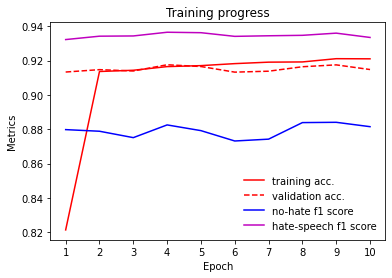

In [30]:
plots([history.history['categorical_accuracy'],
       history.history['val_categorical_accuracy'],
       model.mc.val_f1s0,
       model.mc.val_f1s1],
      ['training acc.', 'validation acc.', 'no-hate f1 score', 'hate-speech f1 score'],
      ['-r', '--r', 'b', 'm'],
      title='Training progress', file_name='results/en_dense/train_progress.png')

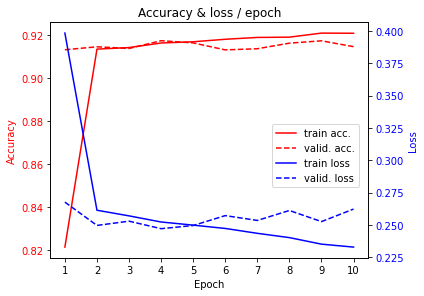

In [31]:
twinx_plot(history.history['categorical_accuracy'], history.history['val_categorical_accuracy'],
           history.history['loss'], history.history['val_loss'],
          x_label='Epoch', y1_label='Accuracy', y2_label='Loss', title='Accuracy & loss / epoch',
          file_name='results/en_dense/acc_loss.png')

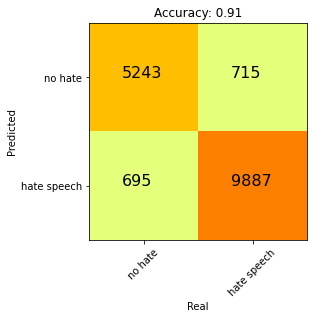

In [32]:
confusion_matrix_plot(conf_mat, cls=classes,
                      x_label='Real', y_label='Predicted',
                      title='Accuracy: {}'.format(round(acc, 2)),
                      file_name='results/en_dense/cm.png')

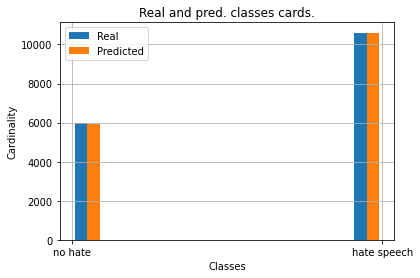

In [33]:
class_distribution_hist(y_true, y_pred, cls=classes,
                        x_label='Classes', y_label='Cardinality', title='Real and pred. classes cards.',
                        file_name='results/en_dense/cards.png')

In [34]:
with open('hsd/Reddit/perfect_data.pkl', 'rb') as f:
    texts, _ = pickle.load(f)
texts = texts[int(0.7*len(texts)):]

indices = [6, 10, 19, 26, 27, 28, 29, 164]
test_cases = []
for i, (t, p, l) in enumerate(zip(texts, y_pred, y_true)):
    if i in indices:
        test_cases.append({'Text': t, 'Prediction': p.numpy(), 'Label': l.numpy()})

In [35]:
def test_cases_board(test_cases, title, file_name=None):
    h = 20
    n = len(test_cases)
    fig, axis = plt.subplots(1, 1, figsize=(16., n*3.2))
    axis.axis('off')
    axis.set_xlim([0, 100])
    axis.set_ylim([0, n*h])
    axis.plot([0, 100], [0, 0], color='k')
    axis.plot([0, 0], [0, n*h], color='k')
    axis.plot([100, 100], [0, n*h], color='k')
    
    for i in range(n):
        axis.annotate('Tweet text:', xy=(4, 16 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        text = u'{}'.format(test_cases[i]['Text'].replace('\n', ''))
        text = '\n'.join([text[j:j+int(len(text)/3)] for j in range(0, len(text), int(len(text)/3))])
        axis.annotate(text, xy=(4, 7 + i*h), xycoords='data', size=15)
        
        axis.annotate('Prediction:', xy=(4, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        pred = 'no hate' if test_cases[i]['Prediction'] == 0 else 'hate speech'
        pred_color = 'b' if pred == 'no hate' else 'm'
        axis.annotate(pred, xy=(15, 4 + i*h), xycoords='data', size=15, color=pred_color)
        
        axis.annotate('Label:', xy=(27, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        label = 'no hate' if test_cases[i]['Label'] == 0 else 'hate speech'
        label_color = 'b' if label == 'no hate' else 'm'
        axis.annotate(label, xy=(34, 4 + i*h), xycoords='data', size=15, color=label_color)
        
        axis.annotate('Result:', xy=(50, 4 + i*h),
                      xycoords='data', size=15, fontweight='bold')
        reason = 'OK' if pred == label else '1-st type error' if pred == 'no hate' else '2-nd type error'
        reason_color = 'g' if reason == 'OK' else 'r'
        axis.annotate(reason, xy=(57, 4 + i*h), xycoords='data', size=15, color=reason_color)
        
        axis.plot([0, 100], [20 + i*h, 20 + i*h], color='k')
    
    
    plt.title(title)
    if file_name:
        plt.savefig(file_name)
    plt.show()

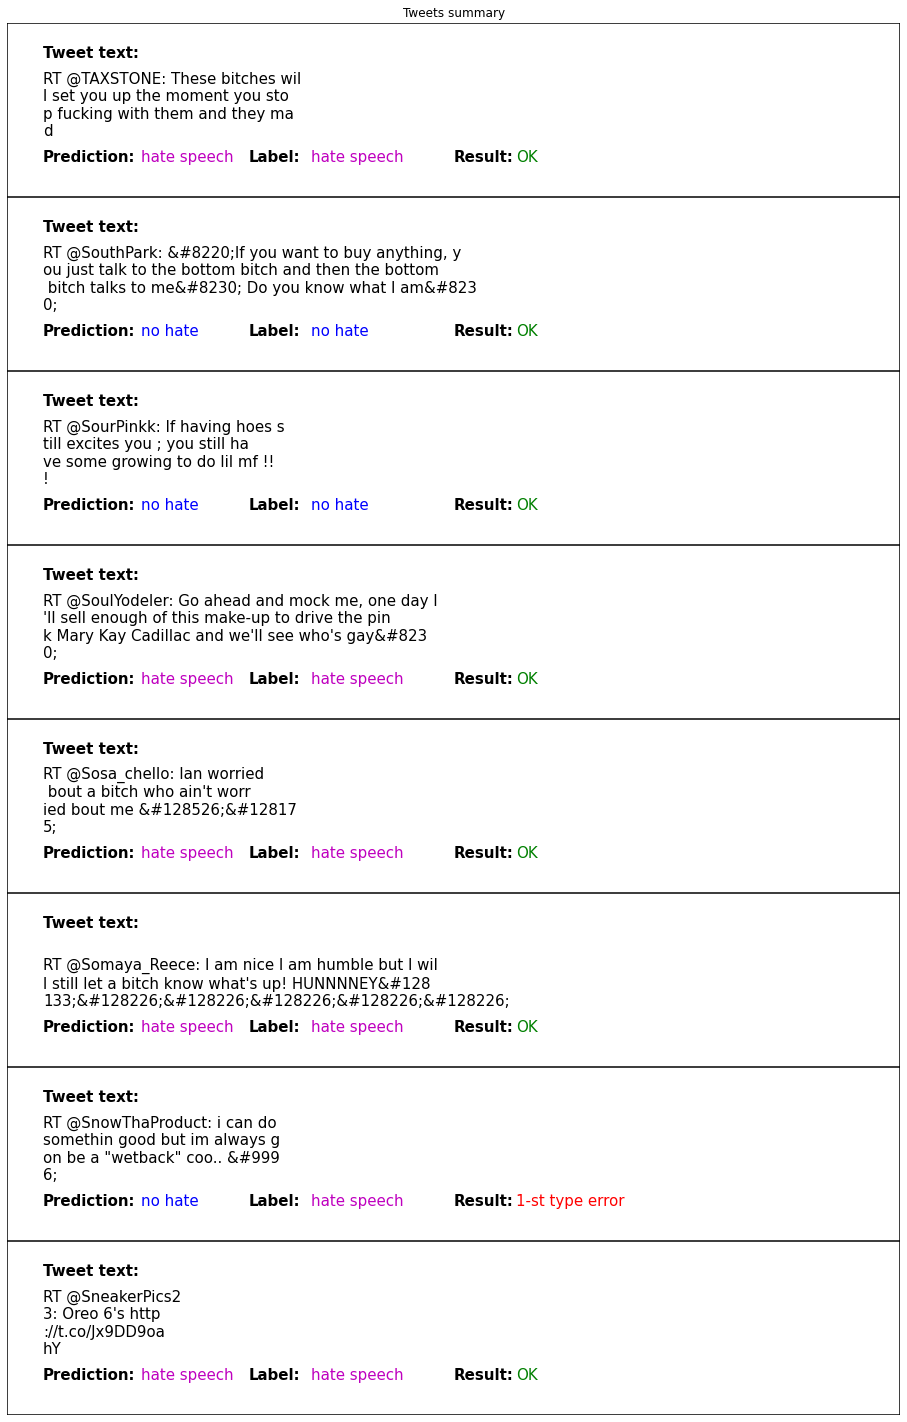

In [36]:
test_cases_board(test_cases, title='Tweets summary', file_name='results/en_dense/tweets_summary.png')